In [1]:
import numpy as np
import qutip as qp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as scp
from time import time

from pnc6.simlib.setup_helpers import interp_pad
fname = 'g_test' #name of g values to load


%matplotlib inline
twopi = 2*np.pi

###  Define Encoding and Operators

In [2]:
# some parameters to set up the problem
d = 5 # hilbert space dimension 13 for coherent at least

# hamiltonian parameters
gvals = np.load(fname+'.npy')
unit_scaling = twopi / 1e3
gvals *= unit_scaling


# timepoints for the solver to return density matricies
npoints = 201
Tmax = 10
tlist = np.linspace(0, Tmax, npoints) #microseconds
T = 10e3 #ns
Tlist = np.arange(0,T)*1e-3 #convert to microseconds

g1_t_r    = interp_pad(Tlist, gvals[0].real, pad = 2000)
g1_t_i    = interp_pad(Tlist, gvals[0].imag, pad = 2000)

g2_t_r    = interp_pad(Tlist, gvals[1].real, pad = 2000)
g2_t_i    = interp_pad(Tlist, gvals[1].imag, pad = 2000)

def g1t_r(t,args):
    return g1_t_r(t)
def g1t_i(t,args):
    return 1j*g1_t_i(t)
def g2t_r(t,args):
    return g2_t_r(t)
def g2t_i(t,args):
    return 1j*g2_t_i(t)


#initial states

#logical qubit weights
alpha = 1. 
beta = 1.
nbar_init = 2

def init_state(alpha, beta, encoding):
    if encoding == 'fock':
        return (alpha*qp.fock(d, 1)+beta*qp.fock(d, 2)).unit()
    if encoding == 'binomial':
        return (alpha*qp.fock(d, 2) + beta/np.sqrt(2)*(qp.fock(d, 0)+qp.fock(d, 4))).unit()
    if encoding == '4cat':
        cat_0L = qp.coherent(nbar_init**0.5)+qp.coherent(-nbar_init**0.5)
        cat_1L = qp.coherent(1j * nbar_init**0.5) + qp.coherent(- 1j * nbar_init**0.5)
        return (alpha * cat_0L + beta * cat_1L).unit()
    else:
        print("Implimented encodings are 'fock' , 'binomial' and '4cat'")


# init_state =  qp.basis(d, 1) # or a single photon
vac = qp.basis(d, 0)

# the full system state is a tensor product of the states of the two modes a and b
psi0 = qp.tensor(init_state(alpha,beta,'fock'), vac , vac, vac)
rho0 = qp.ket2dm(psi0)

# helpful operators for building the hamiltonian
des = qp.destroy(d) # the lowering operator
cre = des.dag() # a dagger, the hermitian conjugate of a
eye = qp.qeye(d) # identity

# joint operators are also tensor products, new format a1, b1, a2, b2
a1 = qp.tensor(des, eye, eye, eye)
a1d = a1.dag()
b1 = qp.tensor(eye, des, eye, eye)
b1d = b1.dag()
a2 = qp.tensor(eye, eye, des, eye)
a2d = a2.dag()
b2 = qp.tensor(eye, eye, eye, des)
b2d = b2.dag()

# collapse operator parameters
eta = 1 #circulator efficiency
kappa_1 = twopi* 1. # MHz loss from mode b1 range 0.5-2 MHz
kappa_2 = twopi* 1. # MHz loss from mode b2

# collapse operaotrs define the lossiness of the b mode
c0 = (kappa_1)**0.5 * b1 + (kappa_2) ** 0.5 * b2
c1 = (eta*kappa_1)**0.5 * b1 + kappa_2**0.5 * b2
c2 = ((1-eta)*kappa_1)**0.5 * b1
c_ops = [c0]

# operators we will use for expectation values later
na1 = a1d * a1
nb1 = b1d * b1
na2 = a2d * a2
nb2 = b2d * b2

# the output field operator
b1out = kappa_1**0.5 * b1
b2out = kappa_2**0.5 * b2

# some plotting goodies
t_label = r'time ($\mu$s)'
field_label = r'Field (a.u.)'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

### Define Hamiltonians

In [3]:
# hamiltonian terms
# conversion (beamsplitter)
# the phase is a convention which makes things look nicer down below

H_pitch_real = 1j * ( a1*b1d - a1d*b1)
H_pitch_im   = 1j * ( a1*b1d + a1d*b1)

H_catch_real = 1j * ( a2*b2d - a2d*b2)
H_catch_im   = 1j * ( a2*b2d + a2d*b2)

H_couple = 1j * (kappa_1*kappa_2/4)**0.5 * (b1d * b2 - b1 * b2d)

H = [H_couple,[H_pitch_real,g1t_r],[H_pitch_im,g1t_i],[H_catch_real,g2t_r],[H_catch_im,g2t_i]]

#Kerr Hamiltonian
# Chi's for Kerr effect
K1 = twopi * .15 # MHz range 0-0.2MHz
K2 = twopi * .15 # MHz

#Kerr Hamiltonian
HK = 0.5 * K1 * b1d * b1d * b1 * b1 + 0.5 * K2 * b2d * b2d * b2 * b2 
H_K = [HK+H_couple,[H_pitch_real,g1t_r],[H_pitch_im,g1t_i],[H_catch_real,g2t_r],[H_catch_im,g2t_i]]


## Kerr-free

In [4]:
# solve the master equation
# returns an object which contains the density matrices at all times (res.states)
t1 = time()
res = qp.mesolve(H, rho0, tlist, c_ops=c_ops)
t2 = time()
print(t2-t1)

15.381093740463257


In [7]:
# calculate expectation values of photon number and output field (~voltage)
na1_vals = np.array([qp.expect(rho, na1) for rho in res.states])
nb1_vals = np.array([qp.expect(rho, nb1) for rho in res.states])
b1out_vals = np.array([qp.expect(rho, b1out) for rho in res.states])

na2_vals = np.array([qp.expect(rho, na2) for rho in res.states])
nb2_vals = np.array([qp.expect(rho, nb2) for rho in res.states])
b2out_vals = np.array([qp.expect(rho, b2out) for rho in res.states])


Text(0, 0.5, 'Field (a.u.)')

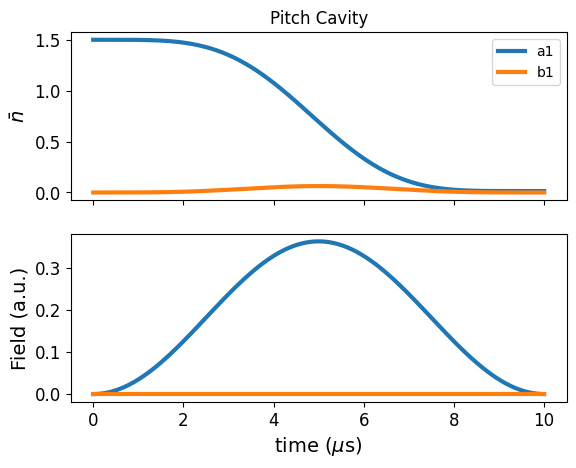

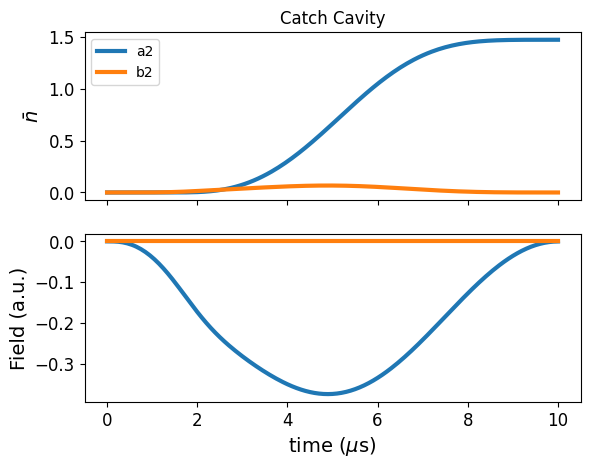

In [8]:
fig, [ax,bx] = plt.subplots(2,1, sharex=True)
lw = 3
ax.plot(tlist, na1_vals, lw=lw, label='a1')
ax.plot(tlist, nb1_vals, lw=lw, label='b1')
ax.set_ylabel(r'$\bar{n}$')
ax.set_title('Pitch Cavity')
ax.legend()

bx.plot(tlist, b1out_vals.real, lw=lw, label='I')
bx.plot(tlist, b1out_vals.imag, lw=lw, label='Q')
bx.set_xlabel(t_label)
bx.set_ylabel(field_label)

fig, [cx,dx] = plt.subplots(2,1, sharex=True)
lw = 3
cx.plot(tlist, na2_vals, lw=lw, label='a2')
cx.plot(tlist, nb2_vals, lw=lw, label='b2')
cx.set_ylabel(r'$\bar{n}$')
cx.set_title('Catch Cavity')
cx.legend()

dx.plot(tlist, b2out_vals.real, lw=lw, label='I')
dx.plot(tlist, b2out_vals.imag, lw=lw, label='Q')
dx.set_xlabel(t_label)
dx.set_ylabel(field_label)

## with kerr

In [9]:
res_K = qp.mesolve(H_K, rho0, tlist, c_ops=c_ops)


In [10]:
na1_vals_K = np.array([qp.expect(rho, na1) for rho in res_K.states])
nb1_vals_K = np.array([qp.expect(rho, nb1) for rho in res_K.states])
b1out_vals_K = np.array([qp.expect(rho, b1out) for rho in res_K.states])

na2_vals_K = np.array([qp.expect(rho, na2) for rho in res_K.states])
nb2_vals_K = np.array([qp.expect(rho, nb2) for rho in res_K.states])
b2out_vals_K = np.array([qp.expect(rho, b1out) for rho in res_K.states])

Text(0, 0.5, 'Field (a.u.)')

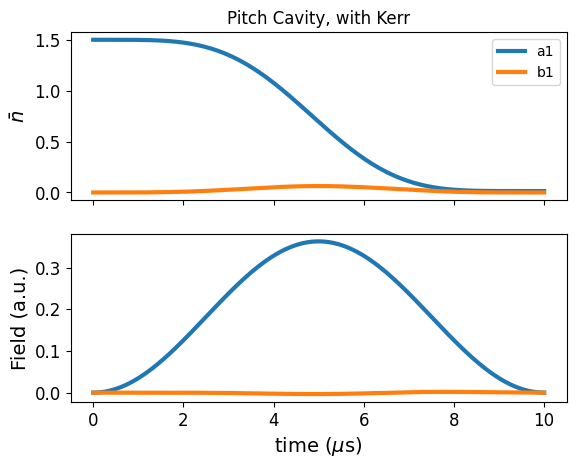

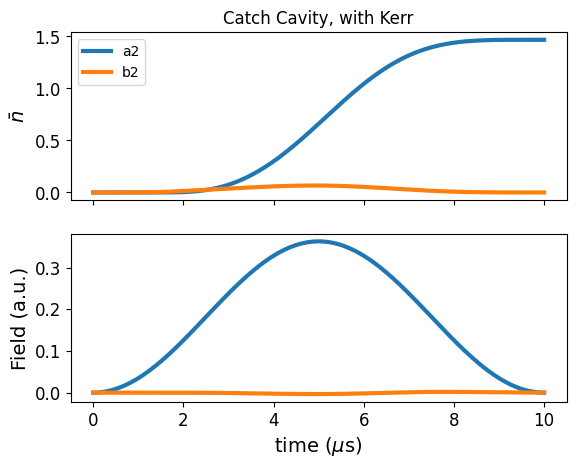

In [11]:
fig, [ax,bx] = plt.subplots(2,1, sharex=True)
lw = 3
ax.plot(tlist, na1_vals_K, lw=lw, label='a1')
ax.plot(tlist, nb1_vals_K, lw=lw, label='b1')
ax.set_ylabel(r'$\bar{n}$')
ax.set_title('Pitch Cavity, with Kerr')
ax.legend()

bx.plot(tlist, b1out_vals_K.real, lw=lw, label='I')
bx.plot(tlist, b1out_vals_K.imag, lw=lw, label='Q')
bx.set_xlabel(t_label)
bx.set_ylabel(field_label)

fig, [cx,dx] = plt.subplots(2,1, sharex=True)
lw = 3
cx.plot(tlist, na2_vals_K, lw=lw, label='a2')
cx.plot(tlist, nb2_vals_K, lw=lw, label='b2')
cx.set_ylabel(r'$\bar{n}$')
cx.set_title('Catch Cavity, with Kerr')
cx.legend()

dx.plot(tlist, b2out_vals_K.real, lw=lw, label='I')
dx.plot(tlist, b2out_vals_K.imag, lw=lw, label='Q')
dx.set_xlabel(t_label)
dx.set_ylabel(field_label)

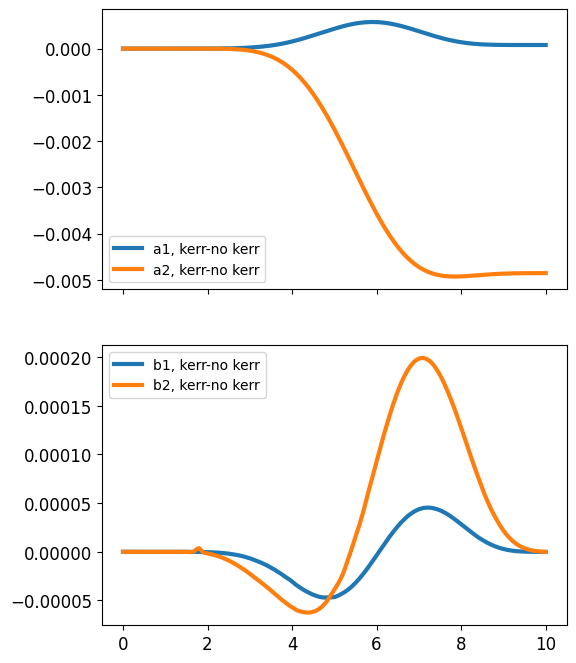

In [12]:
fig, [ax,bx] = plt.subplots(2,1, figsize=(6,2*4), sharex=True)
lw = 3

ax.plot(tlist, na1_vals_K - na1_vals, lw=lw, label='a1, kerr-no kerr')
ax.plot(tlist, na2_vals_K - na2_vals, lw=lw, label='a2, kerr-no kerr')
ax.legend()

bx.plot(tlist, nb1_vals_K - nb1_vals, lw=lw, label='b1, kerr-no kerr')
bx.plot(tlist, nb2_vals_K - nb2_vals, lw=lw, label='b2, kerr-no kerr')
bx.legend()



### Metrics

In [13]:
energy_eta = na2_vals_K[-1]/na1_vals_K[0]
transfer_fidelity = np.abs(qp.fidelity(res_K.states[0].ptrace(0),res_K.states[-1].ptrace(2)))**2 #mod square qutip's 'Fidelity'

print('Energy Transfer Efficiency:', energy_eta)
print('State Transfer Fidelity:', transfer_fidelity)

Energy Transfer Efficiency: 0.9778035084754099
State Transfer Fidelity: 0.9785531721777075


In [14]:
def get_energy_eta(states): #input the states qutip gives for mesolve
    return qp.expect(states[-1], na2)/qp.expect(states[0], na1)

def get_transfer_fidelity(states):
    return np.abs(qp.fidelity(states[0].ptrace(0),states[-1].ptrace(2)))**2 

print(get_energy_eta(res_K.states))
print(get_transfer_fidelity(res_K.states))

res_K = qp.mesolve(H_K, rho0, tlist, c_ops=c_ops)

0.9778035084754099
0.9785531721777075


### For Loops for Different Initial States

In [105]:
def get_efficiencies(encoding):
    coeffs = np.array([[1,0],[0,1],[1,1],[1,-1],[1,1j],[1,-1j]]) #All 6 states on the block sphere
    energies = np.zeros(6)
    fidelities = np.zeros(6)
    for i in range(6):
        (alpha, beta) = coeffs[i]
        psi0 = qp.tensor(init_state(alpha,beta,encoding), vac , vac, vac)
        rho0 = qp.ket2dm(psi0)
        res_K = qp.mcsolve(H_K, psi0, tlist, c_ops=c_ops)
        energies[i] = get_energy_eta(res_K.states)
        fidelities[i] = get_transfer_fidelity(res_K.states)
        
    return energies, fidelities
t1 = time()
energies, fidelities = get_efficiencies('fock') 
t2 = time()
print('Average Energy Transfer Efficiency:', np.mean(energies))
print('Average State Transfer Fidelity:', np.mean(energies))
print('Average execution time:', round((t2 - t1) / 6.,2), 's')
        
        

KeyboardInterrupt: 